In [23]:
import os
from openai import OpenAI

# Test Fireworks client connection
client = OpenAI(
    api_key=os.environ.get("FIREWORKS_API_KEY"),
    base_url="https://api.fireworks.ai/inference/v1"
)

print("Client loaded successfully.")


Client loaded successfully.


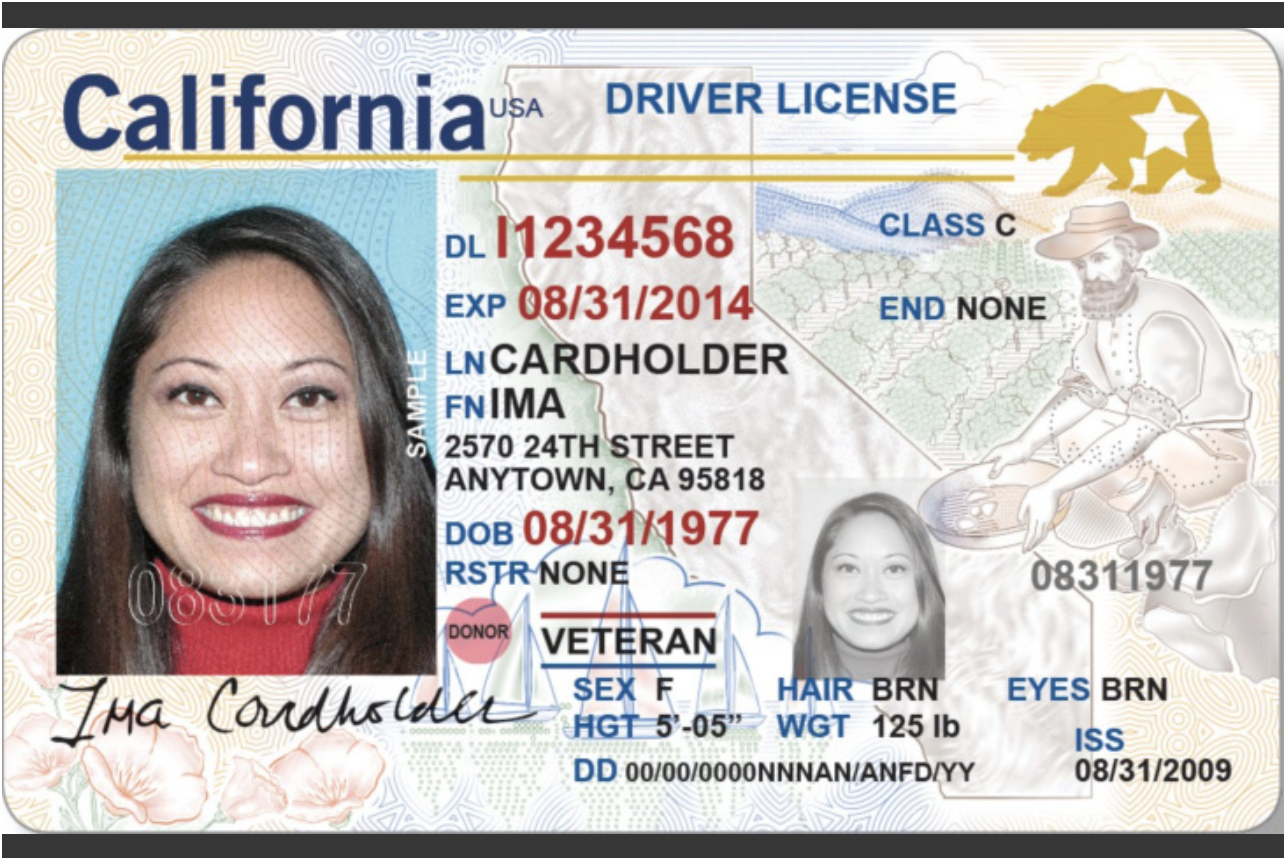

In [24]:
import os
from PIL import Image

image_path = "/Users/ram/Desktop/FireWorks/Images/License 1.png"

# Load & display image
img = Image.open(image_path)
img


In [25]:
import base64

def encode_image_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

image_b64 = encode_image_to_base64(image_path)

# Show first 100 characters to confirm encoding
image_b64[:100]


'iVBORw0KGgoAAAANSUhEUgAABQQAAANcCAYAAAAJk6I7AAAKpmlDQ1BJQ0MgUHJvZmlsZQAASImVlwdUE1sax+/MpBdaAAEpoTdB'

In [26]:
# Lightweight doc-type classifier
classification_prompt = """
Classify the document in the image.
Return exactly one of: passport, drivers_license, other.
"""

cls_response = client.chat.completions.create(
    model="accounts/fireworks/models/llama4-maverick-instruct-basic",
    messages=[
        {"role": "system", "content": classification_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Classify this document."},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_b64}"}
                }
            ]
        }
    ]
)

cls_response.choices[0].message.content.strip().lower()



'drivers_license'

In [27]:
DRIVERS_LICENSE_SCHEMA = {
    "name": "drivers_license_identity",
    "schema": {
        "type": "object",
        "properties": {
            "document_type": {"type": "string"},
            "issuing_state": {"type": "string"},
            "full_name": {"type": "string"},
            "date_of_birth": {"type": "string"},
            "address": {"type": ["string", "null"]},
            "document_number": {"type": "string"},
            "issue_date": {"type": ["string", "null"]},
            "expiry_date": {"type": ["string", "null"]},
            "class": {"type": ["string", "null"]},
            "restrictions": {"type": ["string", "null"]},
            "endorsements": {"type": ["string", "null"]},
            "confidence": {"type": "number"}
        },
        "required": [
            "document_type",
            "issuing_state",
            "full_name",
            "date_of_birth",
            "document_number"
        ]
    }
}


In [28]:
DL_SYSTEM_PROMPT = """
You are a highly accurate KYC extraction engine specialized in Driver's Licenses.

Your job is to extract ONLY the information that is clearly visible on the driver's license image.

### EXTRACTION RULES:
1. Read ONLY visible text; do NOT guess missing information.
2. If a field is not visible, return null for that field.
3. Dates MUST be returned in ISO format: YYYY-MM-DD.
4. Normalize state names (e.g., "CA" → "California").
5. Extract fields exactly as shown (no interpretation or reformatting of names).
6. Use the provided JSON schema EXACTLY — do not add extra fields.
7. Output STRICT JSON only, no explanations.

### FIELDS TO EXTRACT (when visible):
- document_type (always "drivers_license")
- issuing_state
- full_name
- date_of_birth
- address
- document_number
- issue_date
- expiry_date
- class
- restrictions
- endorsements
- confidence

Be strict, precise, and avoid hallucinations.
"""


In [39]:
dl_response = client.chat.completions.create(
    model="accounts/fireworks/models/llama4-maverick-instruct-basic",
    messages=[
        {"role": "system", "content": DL_SYSTEM_PROMPT},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Extract all driver's license identity fields from this image."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_b64}"
                    }
                }
            ]
        }
    ],
    response_format={
        "type": "json_schema",
        "json_schema": DRIVERS_LICENSE_SCHEMA,
    }
)
dl_response


ChatCompletion(id='ad539ca3-c64b-43dc-827b-d991be2bf2b8', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"document_type": "drivers_license", "issuing_state": "California", "full_name": "IMA CARDHOLDER", "date_of_birth": "1977-08-31", "address": "2570 24TH STREET ANYTOWN, CA 95818", "document_number": "I1234568", "issue_date": "2009-08-31", "expiry_date": "2014-08-31", "class": "C", "restrictions": "NONE", "endorsements": "NONE", "confidence": 1}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1763778937, model='accounts/fireworks/models/llama4-maverick-instruct-basic', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=120, prompt_tokens=2108, total_tokens=2228, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetails(audio_tokens=None, cached_tokens=5)))

In [40]:
import json

raw_content = dl_response.choices[0].message.content

if isinstance(raw_content, list):
    extracted_json = "".join(item.get("text", "") for item in raw_content if item.get("type") == "text")
else:
    extracted_json = raw_content

dl_parsed = json.loads(extracted_json)
dl_parsed


{'document_type': 'drivers_license',
 'issuing_state': 'California',
 'full_name': 'IMA CARDHOLDER',
 'date_of_birth': '1977-08-31',
 'address': '2570 24TH STREET ANYTOWN, CA 95818',
 'document_number': 'I1234568',
 'issue_date': '2009-08-31',
 'expiry_date': '2014-08-31',
 'class': 'C',
 'restrictions': 'NONE',
 'endorsements': 'NONE',
 'confidence': 1}